<a href="https://colab.research.google.com/github/MAlam1802/begining-bioinformatics/blob/main/Cross_Ancestry_PRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core scientific + plotting stack
!pip install -q \
    pandas \
    numpy \
    scipy \
    scikit-learn \
    statsmodels \
    matplotlib \
    seaborn \
    tqdm \
    pyarrow


In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 5)

print("Libraries imported and ready.")


Libraries imported and ready.


In [3]:
# install plink 1.9 binary
!wget -qO- http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20201019.zip > plink.zip
!unzip -o plink.zip
!chmod +x plink
!mv plink /usr/local/bin/

!plink --version


Archive:  plink.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                
PLINK v1.90b6.21 64-bit (19 Oct 2020)


In [4]:
import pandas as pd

eur_path = "GCST90320058EUR.h.tsv.gz"
afr_path = "GCST90320061AFR.h.tsv.gz"

# Loading with pandas
eur_df = pd.read_csv(eur_path, sep="\t", compression="gzip", low_memory=False)
afr_df = pd.read_csv(afr_path, sep="\t", compression="gzip", low_memory=False)

print("Loaded EUR GWAS:", eur_df.shape)
print("Loaded AFR GWAS:", afr_df.shape)
print("EUR columns:", list(eur_df.columns))
print("AFR columns:", list(afr_df.columns))


Loaded EUR GWAS: (13264860, 17)
Loaded AFR GWAS: (19077597, 17)
EUR columns: ['chromosome', 'base_pair_location', 'effect_allele', 'other_allele', 'beta', 'standard_error', 'effect_allele_frequency', 'p_value', 'variant_id', 'rsid', 'het_i2', 'het_p_value', 'n_samples', 'n_cases', 'n_studies', 'hm_coordinate_conversion', 'hm_code']
AFR columns: ['chromosome', 'base_pair_location', 'effect_allele', 'other_allele', 'beta', 'standard_error', 'effect_allele_frequency', 'p_value', 'variant_id', 'rsid', 'het_i2', 'het_p_value', 'n_samples', 'n_cases', 'n_studies', 'hm_coordinate_conversion', 'hm_code']


In [5]:
import numpy as np

def clean_gwas(df, label="GWAS"):
    df = df.copy()
    print(f"\n=== Cleaning {label} ===")
    print("Original columns:", list(df.columns))

    # --- 1. Chromosome and position ---
    df["CHR"] = pd.to_numeric(df["chromosome"], errors="coerce")
    df["BP"]  = pd.to_numeric(df["base_pair_location"], errors="coerce")

    # --- 2. SNP ID (rsid preferred) ---
    if "rsid" in df.columns:
        df["SNP"] = df["rsid"]
    else:
        df["SNP"] = df["variant_id"]

    before = df.shape[0]
    df = df[~df["SNP"].isna()]
    print(f"{label}: Dropped {before - df.shape[0]} rows with missing SNP IDs.")

    # --- 3. Alleles ---
    df["A1"] = df["effect_allele"].astype(str).str.upper()
    df["A2"] = df["other_allele"].astype(str).str.upper()

    # --- 4. Effect size, SE, p-value ---
    df["BETA"] = pd.to_numeric(df["beta"], errors="coerce")
    df["SE"]   = pd.to_numeric(df["standard_error"], errors="coerce")
    df["P"]    = pd.to_numeric(df["p_value"], errors="coerce")

    # --- 5. Sample size (n_samples) ---
    df["N"] = pd.to_numeric(df["n_samples"], errors="coerce")

    # --- 6. Keep autosomes only (1–22) ---
    before = df.shape[0]
    df = df[df["CHR"].between(1, 22, inclusive="both")]
    print(f"{label}: Dropped {before - df.shape[0]} non-autosomal rows.")

    # --- 7. Drop rows with missing critical fields ---
    before = df.shape[0]
    df = df.dropna(subset=["CHR", "BP", "SNP", "A1", "A2", "BETA", "SE", "P"])
    print(f"{label}: Dropped {before - df.shape[0]} rows with missing fields.")

    # --- 8. Ensure numeric sanity ---
    before = df.shape[0]
    df = df[
        np.isfinite(df["BETA"]) &
        np.isfinite(df["SE"]) &
        np.isfinite(df["P"]) &
        (df["SE"] > 0)
    ]
    print(f"{label}: Dropped {before - df.shape[0]} rows with invalid numeric values.")

    # --- 9. Final clean selection ---
    clean = df[["CHR", "BP", "SNP", "A1", "A2", "BETA", "SE", "P", "N"]].copy()
    clean = clean.sort_values(["CHR", "BP"]).reset_index(drop=True)

    print(f"{label}: Final clean shape: {clean.shape}")
    return clean

# Clean both GWAS tables
eur_clean = clean_gwas(eur_df, "EUR_ccRCC")
afr_clean = clean_gwas(afr_df, "AFR_ccRCC")

# Save full clean versions
eur_clean_path = "EUR_ccRCC.clean.autosomes.tsv"
afr_clean_path = "AFR_ccRCC.clean.autosomes.tsv"

eur_clean.to_csv(eur_clean_path, sep="\t", index=False)
afr_clean.to_csv(afr_clean_path, sep="\t", index=False)

print("\nSaved clean files:")
print(" ", eur_clean_path)
print(" ", afr_clean_path)

# Create minimal clumping input files
eur_for_clump = eur_clean[["SNP", "CHR", "BP", "P", "A1", "A2", "BETA"]]
afr_for_clump = afr_clean[["SNP", "CHR", "BP", "P", "A1", "A2", "BETA"]]

eur_for_clump_path = "EUR_ccRCC.for_clump.tsv"
afr_for_clump_path = "AFR_ccRCC.for_clump.tsv"

eur_for_clump.to_csv(eur_for_clump_path, sep="\t", index=False)
afr_for_clump.to_csv(afr_for_clump_path, sep="\t", index=False)

print("\nSaved clump files:")
print(" ", eur_for_clump_path)
print(" ", afr_for_clump_path)



=== Cleaning EUR_ccRCC ===
Original columns: ['chromosome', 'base_pair_location', 'effect_allele', 'other_allele', 'beta', 'standard_error', 'effect_allele_frequency', 'p_value', 'variant_id', 'rsid', 'het_i2', 'het_p_value', 'n_samples', 'n_cases', 'n_studies', 'hm_coordinate_conversion', 'hm_code']
EUR_ccRCC: Dropped 0 rows with missing SNP IDs.
EUR_ccRCC: Dropped 445595 non-autosomal rows.
EUR_ccRCC: Dropped 0 rows with missing fields.
EUR_ccRCC: Dropped 0 rows with invalid numeric values.
EUR_ccRCC: Final clean shape: (12819265, 9)

=== Cleaning AFR_ccRCC ===
Original columns: ['chromosome', 'base_pair_location', 'effect_allele', 'other_allele', 'beta', 'standard_error', 'effect_allele_frequency', 'p_value', 'variant_id', 'rsid', 'het_i2', 'het_p_value', 'n_samples', 'n_cases', 'n_studies', 'hm_coordinate_conversion', 'hm_code']
AFR_ccRCC: Dropped 0 rows with missing SNP IDs.
AFR_ccRCC: Dropped 698435 non-autosomal rows.
AFR_ccRCC: Dropped 0 rows with missing fields.
AFR_ccRCC: Dr

In [6]:
# Verifying columns
import pandas as pd
import numpy as np

eur_clean = pd.read_csv("EUR_ccRCC.clean.autosomes.tsv", sep="\t")
afr_clean = pd.read_csv("AFR_ccRCC.clean.autosomes.tsv", sep="\t")

eur_clump = pd.read_csv("EUR_ccRCC.for_clump.tsv", sep="\t")
afr_clump = pd.read_csv("AFR_ccRCC.for_clump.tsv", sep="\t")

print("EUR clean shape:", eur_clean.shape)
print("AFR clean shape:", afr_clean.shape)
print("EUR clump shape:", eur_clump.shape)
print("AFR clump shape:", afr_clump.shape)

print("\nEUR clean columns:", eur_clean.columns.tolist())
print("AFR clean columns:", afr_clean.columns.tolist())
print("\nEUR clump columns:", eur_clump.columns.tolist())
print("AFR clump columns:", afr_clump.columns.tolist())


EUR clean shape: (12819265, 9)
AFR clean shape: (18379162, 9)
EUR clump shape: (12819265, 7)
AFR clump shape: (18379162, 7)

EUR clean columns: ['CHR', 'BP', 'SNP', 'A1', 'A2', 'BETA', 'SE', 'P', 'N']
AFR clean columns: ['CHR', 'BP', 'SNP', 'A1', 'A2', 'BETA', 'SE', 'P', 'N']

EUR clump columns: ['SNP', 'CHR', 'BP', 'P', 'A1', 'A2', 'BETA']
AFR clump columns: ['SNP', 'CHR', 'BP', 'P', 'A1', 'A2', 'BETA']


In [7]:
# Checking consistency and missingness
def quick_qc(df, label):
    print(f"\n=== {label} ===")
    print(df.head())
    print("\nDtypes:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isna().sum())

quick_qc(eur_clean, "EUR_clean")
quick_qc(afr_clean, "AFR_clean")



=== EUR_clean ===
   CHR     BP           SNP A1 A2      BETA        SE         P       N
0    1  13668     rs2691328  A  G -0.482482  0.570721  0.397893  305873
1    1  14773   rs878915777  T  C  0.059339  0.329717  0.857176  305873
2    1  14860   rs533499096  T  G -0.283933  0.318174  0.372188  305873
3    1  17626  rs1230374648  A  G -0.017238  0.402357  0.965828  305873
4    1  17765   rs373918278  A  G  0.562539  0.497359  0.258033  305873

Dtypes:
CHR       int64
BP        int64
SNP      object
A1       object
A2       object
BETA    float64
SE      float64
P       float64
N         int64
dtype: object

Missing values per column:
CHR     0
BP      0
SNP     0
A1      0
A2      0
BETA    0
SE      0
P       0
N       0
dtype: int64

=== AFR_clean ===
   CHR      BP          SNP A1 A2      BETA        SE         P     N
0    1  709040  rs144745434  C  T -0.156402  0.340545  0.646041  3526
1    1  722777  rs879352363  A  G -0.630476  0.479140  0.188225  3024
2    1  722858  rs8798

In [8]:
# checking variant counts
print("EUR variants:", eur_clean.shape[0])
print("AFR variants:", afr_clean.shape[0])


EUR variants: 12819265
AFR variants: 18379162


In [3]:
# analysis setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


In [4]:

eur_on_eur = pd.read_csv("EUR_on_EUR.profile", delim_whitespace=True)
eur_on_afr = pd.read_csv("EUR_on_AFR.profile", delim_whitespace=True)
afr_on_afr = pd.read_csv("AFR_on_AFR.profile", delim_whitespace=True)
afr_on_eur = pd.read_csv("AFR_on_EUR.profile", delim_whitespace=True)

eur_on_eur.head()


/tmp/ipython-input-3770083919.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  eur_on_eur = pd.read_csv("EUR_on_EUR.profile", delim_whitespace=True)
/tmp/ipython-input-3770083919.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  eur_on_afr = pd.read_csv("EUR_on_AFR.profile", delim_whitespace=True)
/tmp/ipython-input-3770083919.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  afr_on_afr = pd.read_csv("AFR_on_AFR.profile", delim_whitespace=True)
/tmp/ipython-input-3770083919.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  afr_on_eur = pd.read_csv("AFR_on_EUR.profile", delim_whitespace=True)


,FID,IID,PHENO,CNT,CNT2,SCORESUM
0,0,HG00096,-9,102,45,-0.061701
1,0,HG00097,-9,102,41,-0.910975
2,0,HG00099,-9,102,43,-0.726391
3,0,HG00100,-9,102,41,-0.349405
4,0,HG00101,-9,102,45,-1.109360


In [5]:
def prepare_profile(df, ancestry, model_label):
    out = df.copy()
    out["ancestry"] = ancestry
    out["model"] = model_label
    out = out.rename(columns={"SCORESUM": "PRS"})
    # keep only relevant columns
    return out[["FID", "IID", "ancestry", "model", "PRS", "CNT", "CNT2"]]

eur_on_eur_long = prepare_profile(eur_on_eur, ancestry="EUR", model_label="EUR_weights")
eur_on_afr_long = prepare_profile(eur_on_afr, ancestry="AFR", model_label="EUR_weights")
afr_on_afr_long = prepare_profile(afr_on_afr, ancestry="AFR", model_label="AFR_weights")
afr_on_eur_long = prepare_profile(afr_on_eur, ancestry="EUR", model_label="AFR_weights")

prs_long = pd.concat(
    [eur_on_eur_long, eur_on_afr_long, afr_on_afr_long, afr_on_eur_long],
    ignore_index=True
)

prs_long.head()


,FID,IID,ancestry,model,PRS,CNT,CNT2
0,0,HG00096,EUR,EUR_weights,-0.061701,102,45
1,0,HG00097,EUR,EUR_weights,-0.910975,102,41
2,0,HG00099,EUR,EUR_weights,-0.726391,102,43
3,0,HG00100,EUR,EUR_weights,-0.349405,102,41
4,0,HG00101,EUR,EUR_weights,-1.109360,102,45


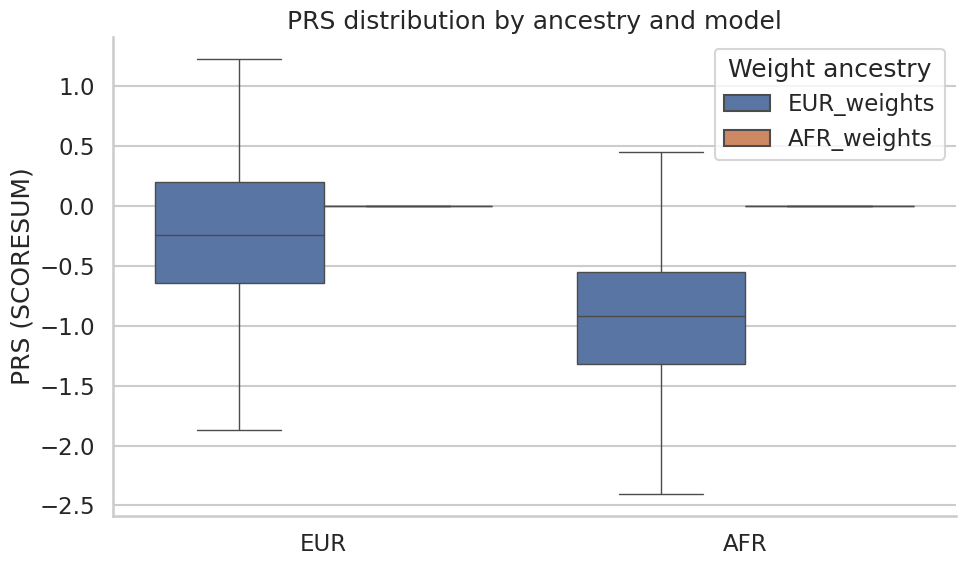

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=prs_long,
    x="ancestry",
    y="PRS",
    hue="model",
    showfliers=False
)
plt.title("PRS distribution by ancestry and model")
plt.ylabel("PRS (SCORESUM)")
plt.xlabel("")
plt.legend(title="Weight ancestry")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2467809546.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


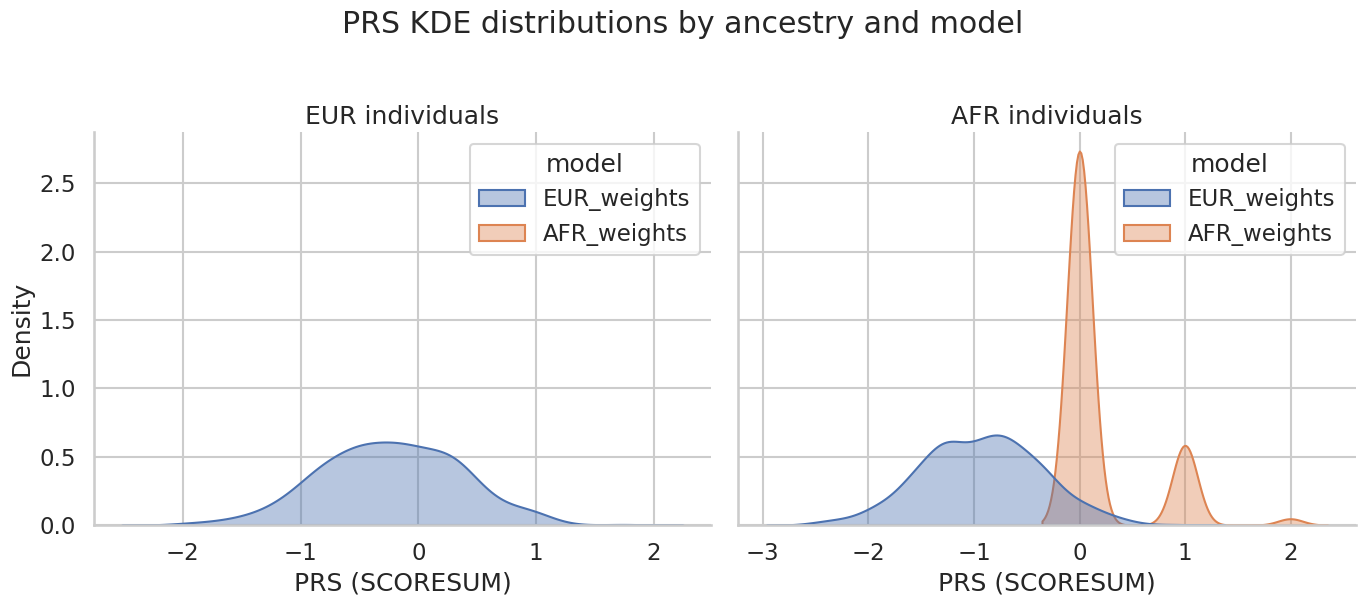

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, anc in zip(axes, ["EUR", "AFR"]):
    subset = prs_long[prs_long["ancestry"] == anc]
    sns.kdeplot(
        data=subset,
        x="PRS",
        hue="model",
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f"{anc} individuals")
    ax.set_xlabel("PRS (SCORESUM)")
    ax.set_ylabel("Density")

plt.suptitle("PRS KDE distributions by ancestry and model", y=1.02)
plt.tight_layout()
plt.show()


In [8]:
summary = (
    prs_long
    .groupby(["ancestry", "model"])
    .PRS
    .agg(["count", "mean", "std", "min", "max"])
    .reset_index()
    .sort_values(["ancestry", "model"])
)

summary


,ancestry,model,count,mean,std,min,max
0,AFR,AFR_weights,652,0.200561,0.433329,0.00000,1.996420
1,AFR,EUR_weights,652,-0.929112,0.559592,-2.50660,0.920708
2,EUR,AFR_weights,503,0.000000,0.000000,0.00000,0.000000
3,EUR,EUR_weights,503,-0.232998,0.589743,-2.00911,1.737880
